# Perrin Freres Monthly Champagne Sales Forecast
### Objective
Create a time-series model to forecast the sales values for Perrin Freres Champagne for the next 12 months in the future

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# configurations
sns.set_style("whitegrid")

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load dataset
df = pd.read_csv("perrin-freres-monthly-champagne-.csv")

In [3]:
# preview dataset
df.head()

,Month,\tPerrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [4]:
df.tail()

,Month,\tPerrin Freres monthly champagne sales millions ?64-?72
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [5]:
# shape of dataset
print("# Rows : ", df.shape[0])
print("# Cols : ", df.shape[1])

# Rows :  107
# Cols :  2


In [6]:
# drop last two rows
df.drop(df.tail(2).index, inplace=True)

# update feature names
df.columns = ['Month','Sales']

In [7]:
# update 'Month' type
df['Month'] = pd.to_datetime(df['Month'])

# set index
df = df.set_index('Month')

# set frequency
df.index.freq = 'MS'

In [8]:
# preview dataset
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [9]:
df.tail()

,Sales
Month,
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0
1972-08-01,1413.0
1972-09-01,5877.0


- dataset spans from Jan 1964 to Sep 1972
- Almost 9 years

In [10]:
# check for missing values
df.isnull().sum()

Sales    0
dtype: int64

- no missing values in the dataset

# Visualize Dataset

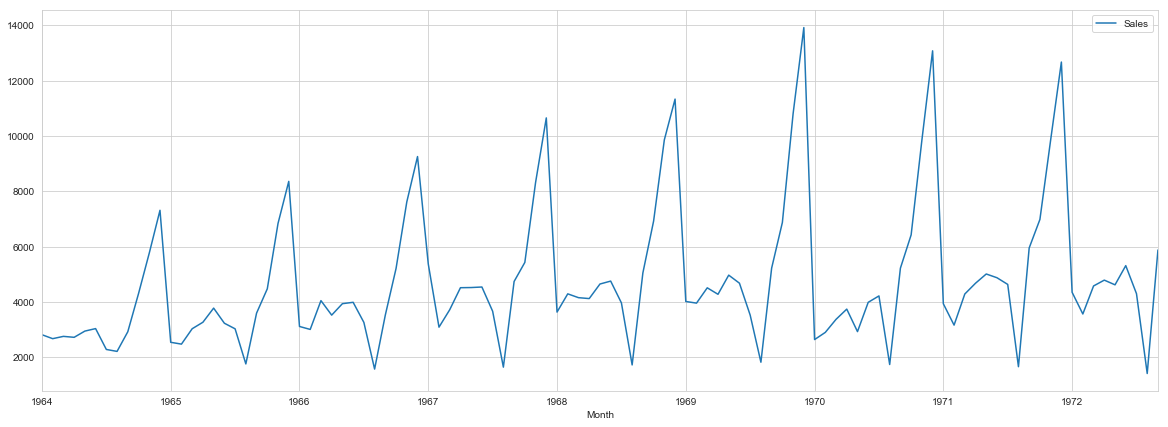

In [31]:
df.plot(figsize=(20,7))

- seasonality is evident every year
- minimal trend is present as well

# Check for stationarity
- Augmented Dickey Fuller Test

In [14]:
# UDF for Augmented Dickey-Fuller Test

from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("\nFinal result")
        print("-> Strong evidence against the null hypothesis")
        print("-> Reject the null hypothesis")
        print("-> Data has no unit root and is STATIONARY")
    else:
        print("\nFinal result")
        print("-> Weak evidence against the null hypothesis")
        print("-> Fail to reject the null hypothesis")
        print("-> Data has a unit root and is NON-STATIONARY")

In [16]:
# check stationarity
adf_test(df['Sales'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -1.833593
p-value                  0.363916
# lags used             11.000000
# observations          93.000000
critical value (1%)     -3.502705
critical value (5%)     -2.893158
critical value (10%)    -2.583637

Final result
-> Weak evidence against the null hypothesis
-> Fail to reject the null hypothesis
-> Data has a unit root and is NON-STATIONARY


## ETF Decompose

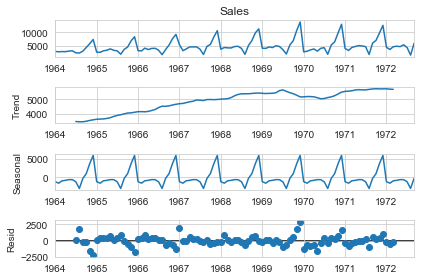

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

# run a ETF decompose to confirm seasonality
result = seasonal_decompose(df['Sales'], model='add')
result.plot();

- There is a general upwards trend in the dataset
- There is a seasonality every 12 months

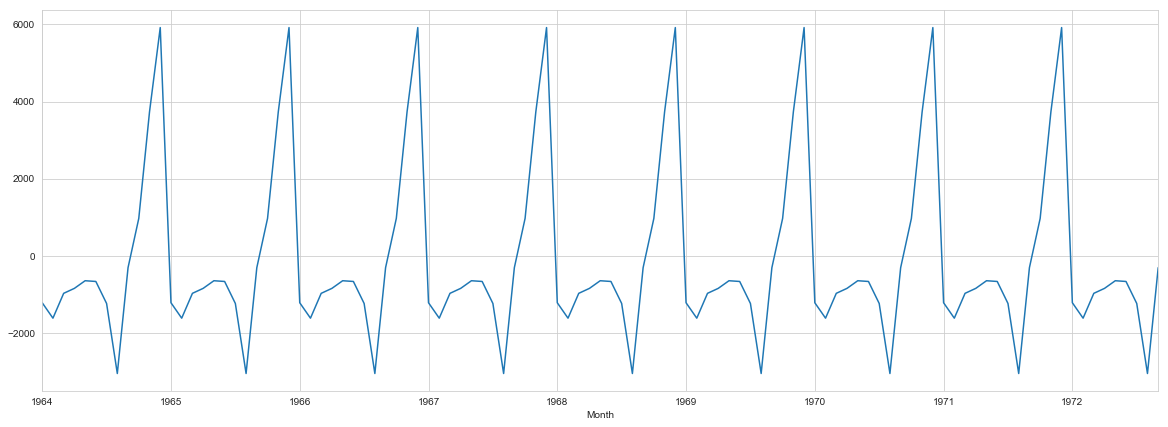

In [30]:
# plot seasonality
result.seasonal.plot(figsize=(20,7))

- seasonality repeats every 12 months

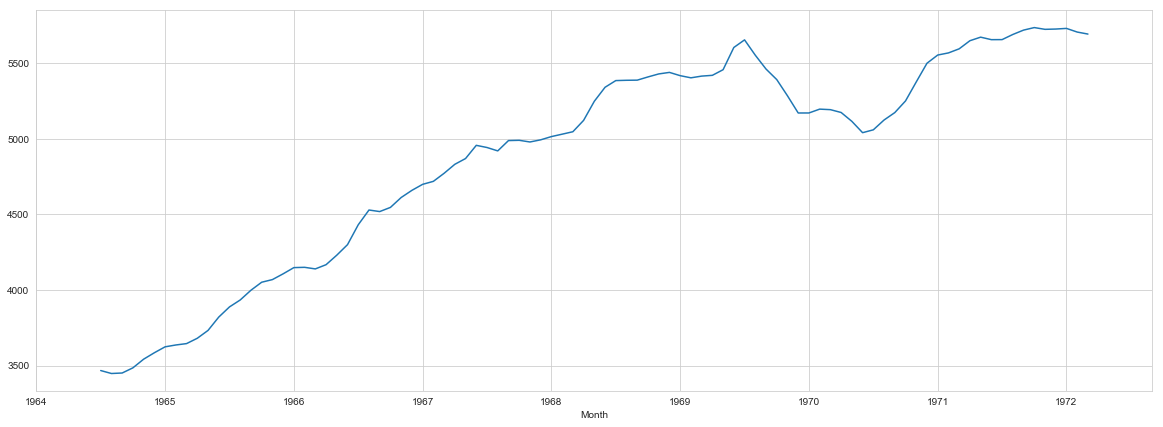

In [29]:
# plot trend
result.trend.plot(figsize=(20,7))

- sharp drop in 1970
- but it picked up later

# Make Data Stationary
- Differencing

In [32]:
# First order differencing
df['1D_Sales'] = df['Sales'] - df['Sales'].shift(1)

In [33]:
df.head()

,Sales,1D_Sales
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,-143.0
1964-03-01,2755.0,83.0
1964-04-01,2721.0,-34.0
1964-05-01,2946.0,225.0


In [34]:
# Seasonal differencing (12th order differencing)
df['12D_Sales'] = df['Sales'] - df['Sales'].shift(12)

In [35]:
df.head(15)

,Sales,1D_Sales,12D_Sales
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN
1964-06-01,3036.0,90.0,NaN
1964-07-01,2282.0,-754.0,NaN
1964-08-01,2212.0,-70.0,NaN
1964-09-01,2922.0,710.0,NaN


## ADF Test for Stationarity

In [36]:
# test stationarity on 1st order differencing
adf_test(df['1D_Sales'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.189896e+00
p-value                 2.519620e-10
# lags used             1.100000e+01
# observations          9.200000e+01
critical value (1%)    -3.503515e+00
critical value (5%)    -2.893508e+00
critical value (10%)   -2.583824e+00

Final result
-> Strong evidence against the null hypothesis
-> Reject the null hypothesis
-> Data has no unit root and is STATIONARY


In [38]:
# test stationarity on seasonal differencing (12th order)
adf_test(df['12D_Sales'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.626619e+00
p-value                 2.060580e-11
# lags used             0.000000e+00
# observations          9.200000e+01
critical value (1%)    -3.503515e+00
critical value (5%)    -2.893508e+00
critical value (10%)   -2.583824e+00

Final result
-> Strong evidence against the null hypothesis
-> Reject the null hypothesis
-> Data has no unit root and is STATIONARY


- Both differenced datasets are STATIONARY

# Train-Test Split

In [39]:
len(df)

105

In [40]:
train = df.iloc[:-12]
test = df.iloc[-12:]

In [41]:
len(train)

93

In [42]:
len(test)

12

# Determine Parameters - `p`, `d`, `q`

### Autocorrelation and Partial Autocorrelation plots

- p,d,q parameters
    - p AR model lags - determined by PACF plot
    - d differencing 
    - q MA lags - determined by ACF plot

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

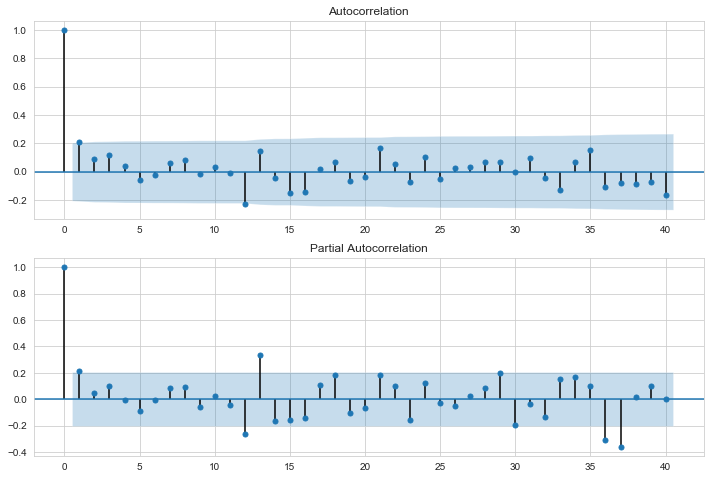

In [44]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['12D_Sales'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['12D_Sales'].iloc[13:],lags=40,ax=ax2)

**Paramters suggested by ACF & PACF plots**
- p = 1 (from PACF)
- q = 1 (from ACF)
- d = 1 (1 season = 12 months)

### Parameters by Auto Arima function

In [47]:
from pmdarima import auto_arima

# run auto_arima
auto_arima(df['12D_Sales'].dropna(), seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   93
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -742.176
Date:                            Sat, 21 Mar 2020   AIC                           1492.351
Time:                                    14:09:25   BIC                           1502.482
Sample:                                         0   HQIC                          1496.442
                                             - 93                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    263.7874     89.090      2.961      0.003      89.174     438.400
ar.L1          0.2881      0.067      4.327      0.000       0.158       0.419
ar.S.L12      -0.2920      0.098     -2.991      0.003      -0.483      -0.101
sigma2      4.941e+05   5.49e+04      9.006      0.000    3.87e+05    6.02e+05
===================================================================================
Ljung-Box (Q):                       32.67   Jarque-Bera (JB):                12.72
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                            -0.23
Prob(H) (two-sided):                  0.50   Kurtosis:                         4.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Paramters suggested by Auto Arima**
- p = 1
- d = 0
- q = 0
- seasonal order = 12

**NOTE** : Auto Arima model is recently not producing accurate results due to an internal error. Therefore we should stick to our results obtained by observing the ACF & PACF plots

# Model - SARIMA
- since the data is seasonal

In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Model 1
- p = 1
- d = 1
- q = 1
- seasonal order = 12

In [49]:
model = SARIMAX(train['Sales'], order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   93
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -645.640
Date:                            Sat, 21 Mar 2020   AIC                           1301.280
Time:                                    14:16:54   BIC                           1313.190
Sample:                                01-01-1964   HQIC                          1306.055
                                     - 09-01-1971                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2985      0.090      3.304      0.001       0.121       0.476
ma.L1         -0.9465      0.049    -19.127      0.000      -1.043      -0.850
ar.S.L12      -0.6172      0.269     -2.294      0.022      -1.145      -0.090
ma.S.L12       0.3745      0.282      1.328      0.184      -0.178       0.927
sigma2      5.398e+05   7.17e+04      7.530      0.000    3.99e+05     6.8e+05
===================================================================================
Ljung-Box (Q):                       38.97   Jarque-Bera (JB):                 4.66
Prob(Q):                              0.52   Prob(JB):                         0.10
Heteroskedasticity (H):               1.91   Skew:                            -0.20
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [70]:
# make predictions on test data
start = len(train)
end = len(train) + len(test) - 1
predictions = model_fit.predict(start=start, end=end).rename("Predictions on Test Data")

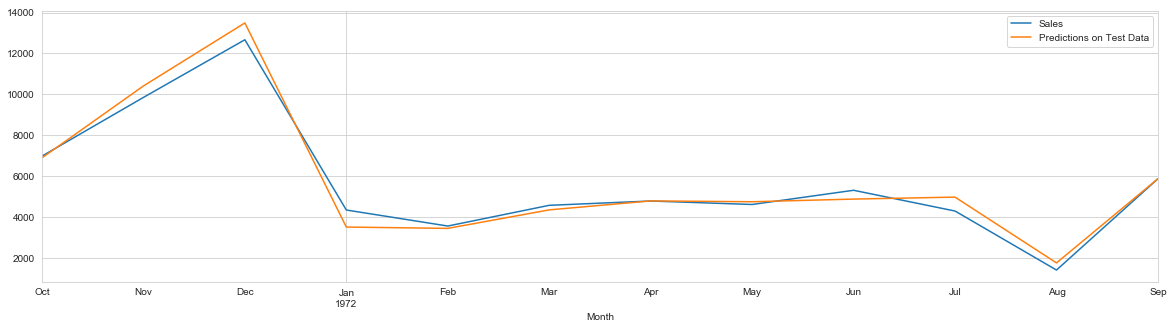

In [71]:
# compare predictions with test data
test['Sales'].plot(figsize=(20,5), legend=True)
predictions.plot(legend=True)

- model predictions are pretty close to the test values

## Model evaluation

In [56]:
# mean of test dataset
test['Sales'].mean()

5691.416666666667

In [57]:
# mean of predictions
predictions.mean()

5771.835636539935

In [55]:
from statsmodels.tools.eval_measures import rmse

# calculate loss
loss = rmse(test['Sales'], predictions)
loss

501.5704820435553

- The model has produced very low loss
- Therefore, the model has predicted pretty accurately

# Forecast into future data

In [69]:
# train model on complete dataset
model = SARIMAX(df['Sales'], order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -738.402
Date:                            Sat, 21 Mar 2020   AIC                           1486.804
Time:                                    14:35:08   BIC                           1499.413
Sample:                                01-01-1964   HQIC                          1491.893
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2790      0.081      3.433      0.001       0.120       0.438
ma.L1         -0.9494      0.043    -22.334      0.000      -1.033      -0.866
ar.S.L12      -0.4544      0.303     -1.499      0.134      -1.049       0.140
ma.S.L12       0.2450      0.311      0.788      0.431      -0.365       0.855
sigma2      5.055e+05   6.12e+04      8.265      0.000    3.86e+05    6.25e+05
===================================================================================
Ljung-Box (Q):                       40.24   Jarque-Bera (JB):                 8.70
Prob(Q):                              0.46   Prob(JB):                         0.01
Heteroskedasticity (H):               1.18   Skew:                            -0.21
Prob(H) (two-sided):                  0.64   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [90]:
start = len(df)
end = len(df) + 11

In [91]:
# forecast into future
forecast = model_fit.predict(start, end).rename("SARIMAX Forecast")

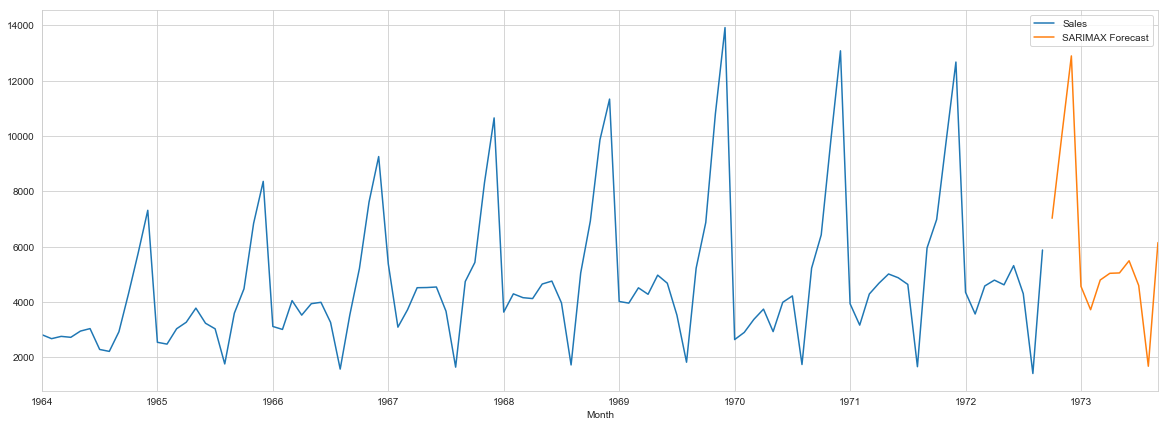

In [92]:
# plot to compare
df['Sales'].plot(figsize=(20,7), legend=True)
# predictions.plot(legend=True)
forecast.plot(legend=True)

In [93]:
# display forecasted values
forecast

1972-10-01     7023.698988
1972-11-01     9996.175660
1972-12-01    12891.997746
1973-01-01     4561.380003
1973-02-01     3718.694977
1973-03-01     4792.240328
1973-04-01     5034.490249
1973-05-01     5047.836575
1973-06-01     5488.453339
1973-07-01     4593.507557
1973-08-01     1676.018322
1973-09-01     6144.750544
Freq: MS, Name: SARIMAX Forecast, dtype: float64